In [1]:
import pyprojroot
import sys

package_path = pyprojroot.here().__str__()
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
!python3 --version

Python 3.8.10


In [5]:
import re
import os
import pickle
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import LoadData, AbsPaths

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Loading and prepare data

In [6]:
final_data='operational_rdbms.csv'
df = LoadData().from_csv(file_name=final_data)
df.loc[:,'tourney_name']=df.tourney_name.str.upper() ###AGREGAR A CALIDAD DE DATOS.

In [7]:
df.head()

,tourney_date,tourney_name,surface,id,ht,wg,age,rank,minutes_played,pj,pg,pp,round
0,2000-01-17,AUSTRALIAN OPEN,Hard,101086.0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,128
1,2000-01-17,AUSTRALIAN OPEN,Hard,101150.0,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,64
2,2000-01-17,AUSTRALIAN OPEN,Hard,101185.0,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,64
3,2000-01-17,AUSTRALIAN OPEN,Hard,101463.0,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,128
4,2000-01-17,AUSTRALIAN OPEN,Hard,101532.0,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,32


In [8]:
def one_hot_codification(data:pd.DataFrame, variable:str):

    new_variables= pd.get_dummies(data[variable], drop_first=True)
    data.loc[:,new_variables.columns]=new_variables
    data=data.drop(columns=variable)
    #data=pd.concat([data.drop(columns=variable),new_variables],axis=1)
    return data

In [9]:
def ordinal_codification(data:pd.DataFrame, variable:str):

    for i,j in enumerate(np.sort(df[variable].unique())):
        data.loc[data[variable]==j,variable+'_cod']=i
    
    data=data.drop(columns=variable)
    return data

In [10]:
def config_inputs(data, nominal_variables=None, ordinal_variables=None):
    if nominal_variables==None:
        nominal_variables=['surface', 'tourney_name']#,'id']
    if ordinal_variables==None:
        ordinal_variables=['round','tourney_date','id']
    for i in nominal_variables:
        data=one_hot_codification(data, i)
    for i in ordinal_variables:
        data=ordinal_codification(data,i)

    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_') for col in data.columns.str.lower()]
    return data

In [11]:
df2=config_inputs(df)

/tmp/ipykernel_322/3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables
/tmp/ipykernel_322/3377404753.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables


In [12]:
df2.head()

,ht,wg,age,rank,minutes_played,pj,pg,pp,grass,hard,roland_garros,us_open,wimbledon,round_cod,tourney_date_cod,id_cod
0,180.0,82.0,36,94.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,1.0
1,180.0,80.0,35,82.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,2.0
2,188.0,88.0,35,126.0,0.0,0.0,0.0,0.0,0,1,0,0,0,5.0,0.0,3.0
3,185.0,73.0,32,139.0,0.0,0.0,0.0,0.0,0,1,0,0,0,6.0,0.0,5.0
4,183.0,71.0,32,39.0,0.0,0.0,0.0,0.0,0,1,0,0,0,4.0,0.0,6.0


# Training model

In [13]:
def make_train_test_split(x, y, test_size = 0.25, random_state = 42):

    (x_train, x_test, y_train, y_test) = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    return x_train, x_test, y_train, y_test

In [14]:
def eval_metrics(y_true, y_pred, y_preb_probs, 
                 labels = None):

    class_report = classification_report(y_true, y_pred, labels=labels)
    roc_auc_score_ = roc_auc_score(y_true, y_preb_probs, average="weighted", multi_class="ovr")
    print(roc_auc_score)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return class_report, roc_auc_score_, mse, mae, r2


In [15]:
def report(estimator, class_report, roc_auc_score_, mse, mae, r2):
    print(estimator, ":", sep="")
    print(f"Classification report: \n {class_report}")
    print(f"  ROC AUC score: {roc_auc_score_}")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")


In [16]:
# -----------------------------------------------------------------------------
# Ya no se requiere con MLflow
# -----------------------------------------------------------------------------
# def save_best_estimator(estimator, 
#                         estimator_name='estimator.pkl',
#                         models_path=None 
#                         ):

#     if models_path is None:
#         try:
#             models_path = AbsPaths().get_abs_path_folder('models')
#         except:
#             models_path = AbsPaths().parent_path+os.sep+'models'
#             os.makedirs(models_path)

#     with open(models_path+estimator_name, "wb") as file:
#         pickle.dump(estimator, file)

In [17]:
# -----------------------------------------------------------------------------
# Ya no se requiere con MLflow
# -----------------------------------------------------------------------------

# def load_best_estimator(estimator_name='estimator.pkl'):
#     try:
#         estimator_path = AbsPaths().get_abs_path_file(estimator_name)
#     except:
#         return None
    
#     with open(estimator_path, 'rb') as fp:
#         estimator = pickle.load(fp)
#         return estimator


In [18]:
def train_estimator(param_grid, x, y,
                    n_iter=5, 
                    n_splits=5, 
                    verbose=1, 
                    path_img=None, 
                    class_names=None):

    x_train, x_test, y_train, y_test = make_train_test_split(x=x, y=y)

    # ------------------------------------------------
    # Búsqueda de parámtetros con validación cruzada

    estimator = RandomizedSearchCV(
        estimator=RandomForestClassifier(
            random_state = 42,
        ),
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = n_splits,
        refit = True,
        verbose = 0 
    )

    # ------------------------------------------------
    estimator.fit(x_train, y_train)

    estimator = estimator.best_estimator_

    class_report, roc_auc_score_, mse, mae, r2 = eval_metrics(y_true=y_test,
                                                              y_pred=estimator.predict(x_test),
                                                              y_preb_probs=estimator.predict_proba(x_test))

    
    if verbose > 0 :
        report(estimator, class_report, roc_auc_score_, mse, mae, r2)

    if class_names is None:
        class_names = y_train.unique()

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None,
        )
    
    if path_img is None:
        try:
            path_img=AbsPaths().get_abs_path_folder(folder_name='figures')
        except:
            path_img = AbsPaths().parent_path+os.sep+'figures'
            os.makedirs(path_img)
    
    plt.savefig(path_img + 'confusion_matrix.png')
    plt.show()

    # Setting tracking of mlflow in models folder
    try:
        models_path = AbsPaths().get_abs_path_folder('models')
    except:
        models_path = AbsPaths().parent_path+os.sep+'models'
        os.makedirs(models_path)
    
    mlflow.set_tracking_uri(f"file:{models_path}"+"mlruns")

    with mlflow.start_run():
        
        # Log params
        params = estimator.get_params()
        
        mlflow.log_param('class_weight', params['class_weight'])
        mlflow.log_param('criterion', params['criterion'])
        mlflow.log_param('max_depth', params['max_depth'])
        mlflow.log_param('n_estimators', params['n_estimators'])

        # Log some metrics
        mlflow.log_metric('roc_auc_score', roc_auc_score_)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Log model
        mlflow.sklearn.log_model(estimator, "model")

        # Log an artifac
        plain_text_path = AbsPaths().get_abs_path_folder('plain-text')
        with open(plain_text_path+'evaluation.txt', "w") as f:
            print(class_report, file=f)

        mlflow.log_artifacts(plain_text_path)

        mlflow.log_artifact(AbsPaths().get_abs_path_folder('figures'))

        



In [19]:
 print(mlflow.get_tracking_uri())

file:///workspace/notebooks/develop/mlruns


In [20]:
param_grid = { 
    'n_estimators': [100, 200, 250, 500],
    # 'max_features': ['sqrt', 'log2'],
    # 'min_samples_split': np.arange(2,16,2),
    'max_depth' : np.arange(1,28,4),
    'criterion' :['gini', 'entropy','log_loss'],
    'class_weight':['balanced', 'balanced_subsample']
}

In [21]:
class_names=list(map(lambda x: 'R-'+str(x) , list(sorted(set(df['round'])))))
class_names

['R-1', 'R-2', 'R-4', 'R-16', 'R-32', 'R-64', 'R-128']

<function roc_auc_score at 0x00000278BAC8EE60>
RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=500,
                       random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.43      0.36      0.39        36
         1.0       0.12      0.05      0.08        37
         2.0       0.05      0.03      0.04        74
         3.0       0.16      0.14      0.15       117
         4.0       0.27      0.17      0.21       258
         5.0       0.25      0.10      0.14       544
         6.0       0.60      0.86      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.27      0.24      0.24      2208
weighted avg       0.42      0.50      0.44      2208

  ROC AUC score: 0.6616699669855098
  MSE: 1.6268115942028984
  MAE: 0.7762681159420289
  R2: 0.10679450702118887


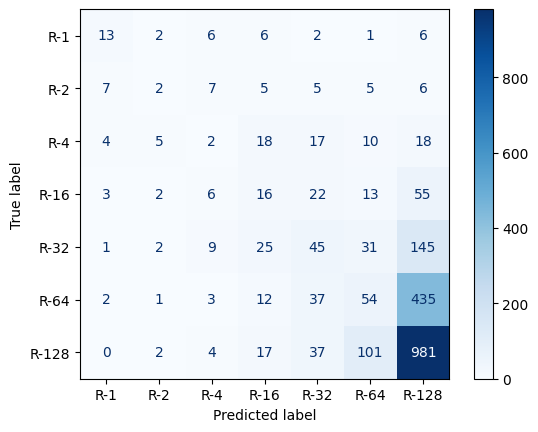

file:['c:\\Users\\johnm\\Desktop\\predict-roland-garros-positions\\models\\', 'c:\\Users\\johnm\\Desktop\\predict-roland-garros-positions\\notebooks\\develop\\mlruns\\models\\']mlruns
file:c:\Users\johnm\Desktop\predict-roland-garros-positions\models\mlruns


In [24]:
x=df2.drop(columns='round_cod')
y=df2.round_cod

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

<function roc_auc_score at 0x00000278BAC8EE60>
RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=250, random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.45      0.42      0.43        36
         1.0       0.10      0.05      0.07        37
         2.0       0.11      0.04      0.06        74
         3.0       0.15      0.11      0.13       117
         4.0       0.26      0.16      0.19       258
         5.0       0.20      0.07      0.10       544
         6.0       0.58      0.87      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.27      0.25      0.24      2208
weighted avg       0.40      0.50      0.43      2208

  ROC AUC score: 0.652870854585054
  MSE: 1.7346014492753623
  MAE: 0.7980072463768116
  R2: 0.047612183154552734


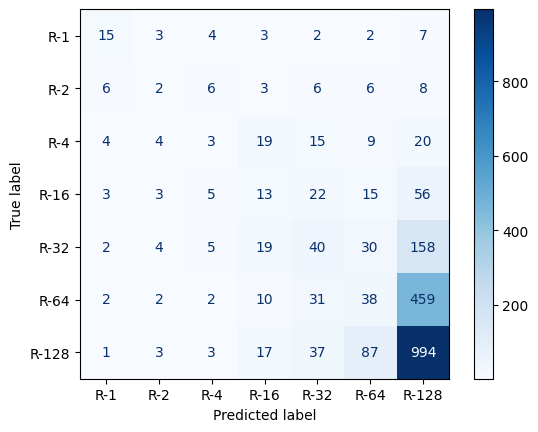

In [19]:
x=df2.drop(['round_cod', 'id_cod'], axis=1)
y=df2['round_cod']

train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

# Make experiments tracking models with mlflow

In [17]:
AbsPaths().parent_path

'/workspace'

In [144]:
def make_experiment(x, y,
                    experiment_name, 
                    param_grid,
                    directory_name = 'mlruns',
                    n_iter=5, 
                    n_splits=5, 
                    verbose=1, 
                    path_img=None, 
                    class_names=None):

    import mlflow
    import mlflow.sklearn

    x_train, x_test, y_train, y_test = make_train_test_split(x=x, y=y)

    estimator = RandomizedSearchCV(
        estimator=RandomForestClassifier(
            random_state = 42,
        ),
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = n_splits,
        refit = True,
        verbose = 0 
    )

    #
    # Establece el directorio de tracking. Esta es la dirección absoluta al
    # directorio actual en este ejemplo.
    #

    try:
        print('try')
        mlruns_path = AbsPaths().get_abs_path_folder(f'{directory_name}')
        print(mlruns_path)
    except:
        print('except')
        models_path = AbsPaths().get_abs_path_folder('models')
        mlruns_path = models_path+f'{directory_name}'
        os.makedirs(mlruns_path)
        print(mlruns_path)
        
    print(mlruns_path)
    mlflow.set_tracking_uri(f"file:{os.sep}{os.sep}{mlruns_path}")
    print("Tracking directory:", mlflow.get_tracking_uri())


    #
    # Autotracking
    #
    mlflow.sklearn.autolog(
        log_input_examples=False,
        log_model_signatures=True,
        log_models=True,
        disable=False,
        exclusive=False,
        disable_for_unsupported_versions=False,
        silent=False,
        max_tuning_runs=10,
        log_post_training_metrics=True,
        serialization_format="cloudpickle",
        registered_model_name=None,
    )

    #
    # Almancena las corridas  en el experimento indicado
    #
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run() as run:

        run = mlflow.active_run()
        print("Active run_id: {}".format(run.info.run_id))

        estimator.fit(x_train, y_train)

        #
        # Reporta el mejor modelo encontrado en la corrida
        #
        estimator = estimator.best_estimator_
        class_report, roc_auc_score_, mse, mae, r2 = eval_metrics(y_true=y_test,
                                                              y_pred=estimator.predict(x_test),
                                                              y_preb_probs=estimator.predict_proba(x_test))
        if verbose > 0 :
            report(estimator, class_report, roc_auc_score_, mse, mae, r2)

        if class_names is None:
            class_names = y_train.unique()

        # Confusion matrix
        disp = ConfusionMatrixDisplay.from_estimator(
            estimator,
            x_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=None,
            )

        if path_img is None:
            try:
                path_img=AbsPaths().get_abs_path_folder(folder_name='figures')
                if isinstance(path_img, list):
                    path_img = path_img[0]
            except:
                path_img = AbsPaths().parent_path+os.sep+'figures'
                os.makedirs(path_img)

        plt.savefig(path_img + 'confusion_matrix.png')
        plt.show()

        # Log some metrics
        mlflow.log_metric('roc_auc_score', roc_auc_score_)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)


        # Log an artifac
        plain_text_path = AbsPaths().get_abs_path_folder('plain-text')
        with open(plain_text_path+'evaluation.txt', "w") as f:
            print(class_report, file=f)

        mlflow.log_artifacts(plain_text_path)
        mlflow.log_artifact(AbsPaths().get_abs_path_folder('figures'))

In [150]:
param_grid = { 
    'n_estimators': [200, 250, 500],
    # 'max_features': ['sqrt', 'log2'],
    # 'min_samples_split': np.arange(2,16,2),
    'max_depth' : np.arange(1,28,4),
    'criterion' :['gini', 'entropy','log_loss'],
    'class_weight':['balanced', 'balanced_subsample']
}

In [151]:
class_names=list(map(lambda x: 'R-'+str(x) , list(sorted(set(df['round'])))))
class_names

['R-1', 'R-2', 'R-4', 'R-16', 'R-32', 'R-64', 'R-128']

In [152]:
# AbsPaths(max_level=10).get_abs_path_folder(folder_name='mlruns', deep = 10)

try
/workspace/models/corridas2/
/workspace/models/corridas2/
Tracking directory: file:///workspace/models/corridas2/
Active run_id: 8e122d66205b4e7c8c505e8aaf4ba738


2023/03/23 16:40:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.8/dist-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/03/23 16:40:28 INFO mlflow.sklearn.utils: Logging the 10 best runs, no runs will be omitted.


<function roc_auc_score at 0x7fcbfe995550>
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=17, n_estimators=250, random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.43      0.36      0.39        36
         1.0       0.07      0.03      0.04        37
         2.0       0.08      0.04      0.05        74
         3.0       0.16      0.12      0.14       117
         4.0       0.25      0.15      0.19       258
         5.0       0.27      0.11      0.15       544
         6.0       0.59      0.86      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.26      0.24      0.24      2208
weighted avg       0.42      0.50      0.44      2208

  ROC AUC score: 0.655475513657941
  MSE: 1.6440217391304348
  MAE: 0.7771739130434783
  R2: 0.09734522842063353


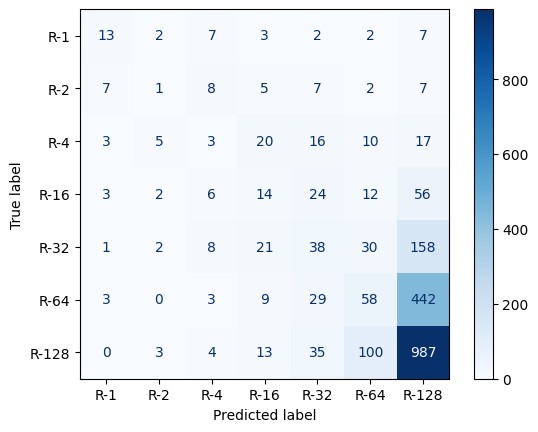

In [153]:
x=df2.drop(columns='round_cod')
y=df2.round_cod

make_experiment(x, y,
    directory_name='corridas2',
    experiment_name='saint-seiya',
    param_grid=param_grid,
    class_names=class_names,
)

try


2023/03/23 16:42:35 INFO mlflow.tracking.fluent: Experiment with name 'inuyasha' does not exist. Creating a new experiment.


/workspace/models/corridas2/
/workspace/models/corridas2/
Tracking directory: file:///workspace/models/corridas2/
Active run_id: 59e7087638c34526947b17b0094e38cb


2023/03/23 16:43:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.8/dist-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/03/23 16:43:37 INFO mlflow.sklearn.utils: Logging the 10 best runs, no runs will be omitted.


<function roc_auc_score at 0x7fcbfe995550>
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=17, n_estimators=200, random_state=42):
Classification report: 
               precision    recall  f1-score   support

         0.0       0.43      0.36      0.39        36
         1.0       0.08      0.03      0.04        37
         2.0       0.10      0.05      0.07        74
         3.0       0.12      0.08      0.09       117
         4.0       0.25      0.16      0.20       258
         5.0       0.24      0.10      0.14       544
         6.0       0.59      0.85      0.70      1142

    accuracy                           0.50      2208
   macro avg       0.26      0.23      0.23      2208
weighted avg       0.41      0.50      0.43      2208

  ROC AUC score: 0.659216110937348
  MSE: 1.723731884057971
  MAE: 0.7989130434782609
  R2: 0.05358014858648241


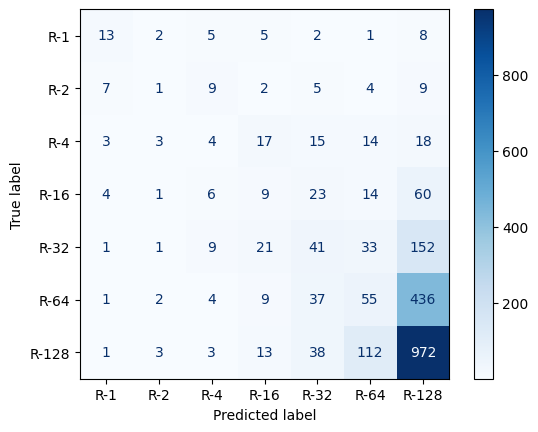

In [155]:
x=df2.drop(['round_cod', 'id_cod'], axis=1)
y=df2['round_cod']


make_experiment(x, y,
    directory_name='corridas2',
    experiment_name='inuyasha',
    param_grid=param_grid,
    class_names=class_names,
)